# Dinámica de Redes Genéticas
## Mariana Escobar Rodríguez

In [27]:
# Import the required modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import random
import math

# This makes the plots appear inside the notebook
%matplotlib inline

**1. Postular las reglas lógicas y una tabla con la función de actualización de un modelo
booleano de una red genética de control transcripcional compuesta por un ciclo de
retroalimentación negativo de tres genes. A esta red se le conoce como represilador.**


**t**

| A | B | C |
| --- | --- | --- |
| 0 | 0 | 0 |
| 0 | 0 | 1 |
| 0 | 1 | 0 |
| 0 | 1 | 1 |
| 1 | 0 | 0 |
| 1 | 0 | 1 |
| 1 | 1 | 0 |
| 1 | 1 | 1 |


**t+1**

| A | B | C |
| --- | --- | --- |
| 0 | 0 | 0 |
| 1 | 0 | 1 |
| 0 | 1 | 0 |
| 1 | 0 | 1 |
| 0 | 1 | 0 |
| 1 | 0 | 1 |
| 0 | 1 | 0 |
| 1 | 0 | 1 |

Al actualizarse, observamos que converge a un estado **oscilante**.

**2. Escribir las ecuaciones diferenciales que describen la dinámica del sistema de un
modelo continuo y determinista del represilador. Describir cada uno de los parámetros y
representar gráficamente la red de interacciones.**

Un represilador es una red genética que consta de tres genes que se inhiben uno al otro.


Para modelar la dinámica de esta red:


El estado en los diferentes tiempos $t$ está representado en el vector $x(t)=(r_a, r_b, r_c, p_a, p_b, p_c)$.


$r_a, r_b$ y $r_c$ representan las concentraciones de mARN y $p_a$,$p_b$ y $p_c$ corresponden a las concentraciones de proteínas traducidas a partir de estos mARN de los genes $A$, $B$, y $C$, respectivamente, mientras que $\delta_a$,$\delta_b$ y $\delta_c$ corresponden a la tasa de degradación de sus proteínas correspondientes. Por su parte, la tasa de degradación de mARN está dada por $\gamma_a$, $\gamma_b$ y $\gamma_c$.

Asumiendo que la traducción depende linealmente de la concentración de su mARN por una constante, $k_a$, $k_b$ y $k_c$ representarán la tasa de traducción de cada proteína .


La transcripción puede modelarse mediante la suma o producto de las concentraciones de los factores transcripcionales.


Para modelar una interacción inhibitoria ($X \dashv Y$) como las de esta red genética, se puede utilizar la función de Hill:

$$
h^-(p; \theta, n)=1-h^+=\frac{\theta^n}{p^n+\theta^n}
$$


Donde $\theta$ denota al umbral de expresión y $n$ al coeficiente de Hill. Dado que el rango de esta función es el intervalo $[0, 1]$, se multiplicarán por una constante que representa la tasa máxima de transcripción. Representado en este caso como $m_a$, $m_b$ y $m_c$ para los genes $A$, $B$ y $C$, respectivamente. 



La dinámica del sistema, $\frac{dx}{dt}=F(x(t))$, puede representarse mediante el siguiente sistema de ecuaciones diferenciales:

$$
\frac{d r_a}{dt}= m_a \, h^-(p_c; \theta_c, n_c) - \gamma_a \, r_a \\   
\frac{d r_b}{dt}= m_b \, h^-(p_a; \theta_a, n_a) - \gamma_b \, r_b \\
\frac{d r_c}{dt}= m_c \, h^-(p_b; \theta_b, n_b) - \gamma_c \, r_c \\
\frac{d p_a}{dt}= k_a \, r_a - \delta_a \, p_a \\
\frac{d p_b}{dt}= k_b \, r_b - \delta_b \, p_b \\
\frac{d p_c}{dt}= k_c \, r_c - \delta_c \, p_c 
$$

con condiciones iniciales:
$\\x(0)=(r_a^0, r_b^0, r_c^0, p_a^0, p_b^0, p_c^0)$.




La red genética puede representarse entonces como

!['Repressilator'](red.png "Repressilator")

**3. Asumir que la dinámica de mRNAs se encuentra en quasi-equilibrio y escribir el sistema
de ecuaciones simplificado que describe el cambio en la concentración de proteínas del sistema.**

$$
\frac{d p_a}{dt}=K_a\big(\frac{r_a}{\gamma_a}h^-(P_c)\big)-\delta_a P_a \\
\frac{d p_b}{dt}=K_b\big(\frac{r_b}{\gamma_b} h^-(P_a)\big)-\delta_b P_b \\
\frac{d p_c}{dt}=K_c\big(\frac{r_c}{\gamma_c} h^-(P_b)\big)-\delta_c P_c
$$

**4. Programar un código que resuelva numéricamente el sistema de ecuaciones
diferenciales propuesto en (2).**

In [2]:
# Definiendo funciones
def F(x, t, params_a, params_b, params_c):
    
    ra, rb, rc, pa, pb, pc = x;
    
    # Cambio concentración mARN
    dradt = params_a['m']*hillI(pc, params_c['theta'], params_c['n']) - params_a['gamma']*ra;                    
    drbdt = params_b['m']*hillI(pa, params_a['theta'], params_a['n']) - params_b['gamma']*rb;
    drcdt = params_c['m']*hillI(pb, params_b['theta'], params_b['n']) - params_c['gamma']*rc;
    
    #nCambio concentración proteínas    
    dpadt = params_a['k']*ra - params_a['delta']*pa;                    
    dpbdt = params_b['k']*rb - params_b['delta']*pb;
    dpcdt= params_c['k']*rc - params_c['delta']*pc;
    
    return [dradt, drbdt, drcdt, dpadt, dpbdt, dpcdt]

# Función de Hill (Inhibidora)
def hillI(p, theta, n):
    return (1-((p**n)/(p**n + theta**n)))
    
# Función de Hill (Activadora) 
def hillA(p, theta, n):
    return (p**n)/(p**n + theta**n)

Definiendo los parámetros y condiciones iniciales:

In [3]:
T=100.   # Tiempo de integración
nT=1000  # Número de pasos

# Parámetros de A

m_a=1.8       # Tasa de transc. máxima
theta_a=.6542; # Parámetro de Hill 
n_a=3.          # Coeficiente de Hill
gamma_a=1.      # Tasa de degracación de mRNA
delta_a=1.      # Tasa de degradación de proteínas
k_a=1.          # Tasa de traducción

# Parámetros de B
m_b=1.8        # Tasa de transc. máxima 
theta_b=.6542; # Parámetro de Hill 
n_b=3.          # Coeficiente de Hill
gamma_b=1.      # Tasa de degracación de mRNA
delta_b=1.      # Tasa de degradación de proteínas
k_b=1.          # Tasa de traducción

# Ps añadámosle el de C :v
m_c=1.8        # Tasa de transc. máxima 
theta_c=.6542; # Parámetro de Hill
n_c=3.          # Coeficiente de Hil
gamma_c=1.      # Tasa de degracación de mRNA
delta_c=1.      # Tasa de degradación de proteínas
k_c=1.          # Tasa de traducción

# Condiciones iniciales
ra0=1.
rb0=1.
rc0=1.
pa0=1.
pb0=1.
pc0=1.

Resolviendo sistema de ecuaciones con las consideraciones anteriores:

In [4]:
params_a={'m':m_a, 'theta':theta_a, 'n':n_a, 'gamma':gamma_a, 'delta':delta_a,'k':k_a}
params_b={'m':m_b, 'theta':theta_b, 'n':n_b, 'gamma':gamma_b, 'delta':delta_b,'k':k_b}
params_c={'m':m_c, 'theta':theta_c, 'n':n_c, 'gamma':gamma_c, 'delta':delta_c,'k':k_c}

t = np.linspace(0,T,nT)     
x0 = [ra0, rb0, rc0, pa0, pb0, pc0]    

xt = odeint(F, x0, t, args=(params_a, params_b, params_c))

**5. Graficar la concentración de proteínas y mRNAs en función del tiempo de la red
simulada en (4), así como el plano fase. Discutir la dinámica del sistema resultante y evaluar el
efecto de modificar distintos parámetros en la dinámica del sistema.**

Cambio de concentración de mARN y proteínas en función del tiempo:

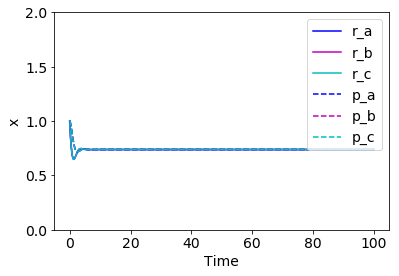

In [5]:
plt.rcParams.update({'font.size': 14})  # increase the font size
plt.xlabel("Time")
plt.ylabel("x")
plt.plot(t, [row[0] for row in xt], label='r_a', color='b');
plt.plot(t, [row[1] for row in xt], label='r_b', color='m');
plt.plot(t, [row[2] for row in xt], label='r_c', color='c');
plt.plot(t, [row[3] for row in xt],'--', label='p_a', color='b');
plt.plot(t, [row[4] for row in xt],'--', label='p_b', color='m');
plt.plot(t, [row[5] for row in xt],'--', label='p_c', color='c');
plt.ylim([0,2])
plt.legend(loc='upper right')

Plano fase:

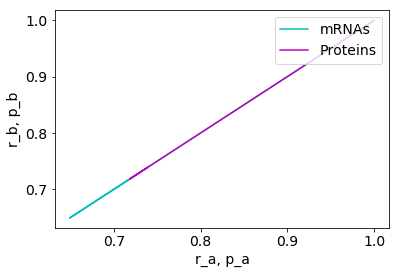

In [6]:
plt.xlabel("r_a, p_a")
plt.ylabel("r_b, p_b")

plt.plot([row[0] for row in xt],[row[1] for row in xt], label='mRNAs', color='c');
plt.plot([row[3] for row in xt],[row[4] for row in xt], label='Proteins', color='m');
xt
plt.legend(loc='lower right')

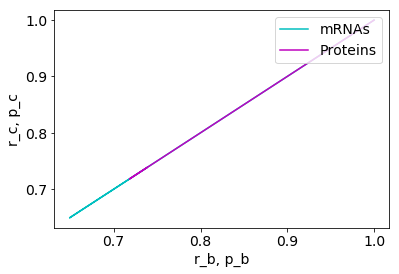

In [7]:
plt.xlabel("r_b, p_b")
plt.ylabel("r_c, p_c")

plt.plot([row[1] for row in xt],[row[2] for row in xt], label='mRNAs', color='c');
plt.plot([row[4] for row in xt],[row[5] for row in xt], label='Proteins', color='m');
xt
plt.legend(loc='lower right')

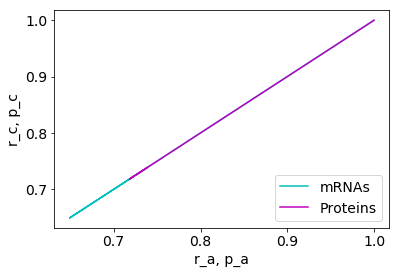

In [8]:
plt.xlabel("r_a, p_a")
plt.ylabel("r_c, p_c")

plt.plot([row[0] for row in xt],[row[2] for row in xt], label='mRNAs', color='c');
plt.plot([row[3] for row in xt],[row[5] for row in xt], label='Proteins', color='m');
xt
plt.legend(loc='lower right')

En este caso observamos estados estáticos en la concentración de todas las proteínas y mARNs de los tres genes.
En el diagrama fase, vemos que correlacionan linealmente las tres diferentes combinaciones de proteínas y mRNAs.
En situaciones reales, los parámetros para cada componente de la red pueden ser diferentes o presentar fluctuaciones.
Es por esto que pequeñas perturbaciones en estos parámetros pueden alterar la dinámica del sistema, que puede terminar en un estado oscilante, por ejemplo:

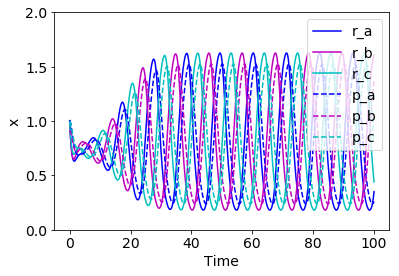

In [9]:
# Pequeños cambios en las condiciones iniciales (originalmente 1)
pa0=1.01
pb0=0.9
pc0=1.

x0 = [ra0, rb0, rc0, pa0, pb0, pc0]    
xt = odeint(F, x0, t, args=(params_a, params_b, params_c))

plt.rcParams.update({'font.size': 14})  # increase the font size
plt.xlabel("Time")
plt.ylabel("x")
plt.plot(t, [row[0] for row in xt], label='r_a', color='b');
plt.plot(t, [row[1] for row in xt], label='r_b', color='m');
plt.plot(t, [row[2] for row in xt], label='r_c', color='c');
plt.plot(t, [row[3] for row in xt],'--', label='p_a', color='b');
plt.plot(t, [row[4] for row in xt],'--', label='p_b', color='m');
plt.plot(t, [row[5] for row in xt],'--', label='p_c', color='c');
plt.ylim([0,2])
plt.legend(loc='upper right')

Entonces, la onvergencia hacia un estado oscilante pareciera depender del error relativo de los parámetros.
Observemos sus diagramas de fase:

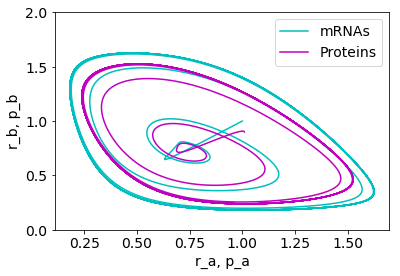

In [10]:
plt.xlabel("r_a, p_a")
plt.ylabel("r_b, p_b")

plt.plot([row[0] for row in xt],[row[1] for row in xt], label='mRNAs', color='c');
plt.plot([row[3] for row in xt],[row[4] for row in xt], label='Proteins', color='m');
plt.ylim([0,2])
plt.legend(loc='upper right')

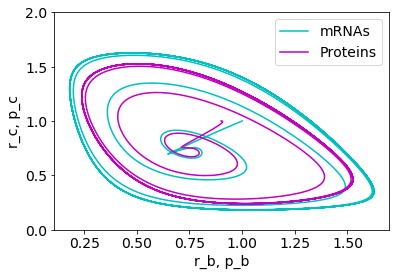

In [11]:
plt.xlabel("r_b, p_b")
plt.ylabel("r_c, p_c")

plt.plot([row[1] for row in xt],[row[2] for row in xt], label='mRNAs', color='c');
plt.plot([row[4] for row in xt],[row[5] for row in xt], label='Proteins', color='m');
plt.ylim([0,2])
plt.legend(loc='upper right')

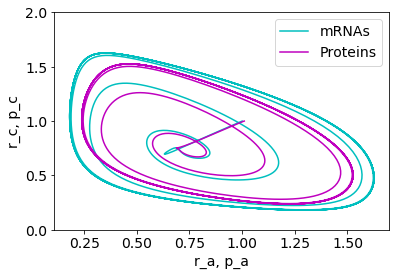

In [15]:
plt.xlabel("r_a, p_a")
plt.ylabel("r_c, p_c")

plt.plot([row[0] for row in xt],[row[2] for row in xt], label='mRNAs', color='c');
plt.plot([row[3] for row in xt],[row[5] for row in xt], label='Proteins', color='m');
plt.ylim([0,2])
plt.legend(loc='upper right')

En los diagramas de fase observamos que se comienza de un estado más o menos estable que comienza a oscilar, lo que es coherente con el diagrama de la concentración de proteínas y mRNAs.
Interesantemente, esto demuestra que perturbaciones muy pequeñas pueden llevar al sistema a una dinámica con oscilaciones muy marcadas.

**6.Escribir una tabla con reacciones y propensiones de un modelo estocástico del
represilador6. que se utilizan para simular la dinámica del sistema con algoritmos de Gillespie.**

Considerando que La reacción $A->B$ tiene la probabilidad por unidad de tiempo (propensión) $a_1$, la reacción $B->C$ tiene la probabilidad por uidad de tiempo (propensión) $a_2$ y la reacción $C->A$ tiene la probabilidad por unidad de tiempo (propensión) $a_3$.


| $A->B$ | $B->C$ | $C->A$ |
| --- | --- | --- |
| $\frac{a_1}{a_1+a_2+a_3}$  | $\frac{a_2}{a_1+a_2+a_3}$  | $\frac{a_3}{a_1+a_2+a_3}$  |

En general, la probabilidad de que la siguiente reacción sea $x$ es $\frac{a_x}{a_0}$, siendo $a_0$ la suma de las propensiones.

In [102]:
" ESTO CREO QUE ESTÁ MAL. LO SIENTO. LO HICE OCN MIS LAGRIMAS"

pa=((1/3)/((1/3)*3))
pb=((2/3)/((1/3)*3))
pc=((3/3)/((1/3)*3))
ao=1

r1=random.random()
r2=random.uniform(0,1)
treact=(1/ao)*math.log(1/r1)
((1/3)/((1/3)*3))



#Thus, we need to generate exponentially distributed reactiontimes.
rand=random.uniform(0,1)
# Convertirlo a exponencial
#r2=3.33
for i in range(1,100):
    r1=random.uniform(0,1)
    treact=(1/ao)*math.log(1/r1) #Tiempo de reacción aleatorio
    pa=(1/3)*treact
    pb=(1/3)*treact
    pc=(1/3)*treact
    ao=pa+pb+pc
    r2=random.uniform(0,1)
    mu=r2/ao
    pmu=mu/treact
    #print(mu)
    print(pmu)
    

0.8601900790378225
0.5483619646008979
0.1148584889273797
2.26865758023479
1.2909139489544776
0.0810702336510968
0.5575599294440502
0.06495413611599694
9.106929576257361
0.0008707918654752933
548.8119297382717
0.010120894516338904
7.261900736121613
0.2149262743732531
21.907462113793024
0.06544788854303231
0.7784671336083284
0.06942063325114194
3.434817094577913
0.00346992401193613
676.1617840937562
0.0001462303758600596
5533.359786063626
0.0001736135330757352
110893.02580228807
5.007354794251468e-06
182986.50718423387
3.001041610691543e-07
5019379885.548271
2.6763920331835527e-11
1063548022.660807
3.1518711660476262e-09
37519266.675877325
2.321202425970556e-11
270096962.58148193
8.060700357430137e-11
1209386743.1686993
2.495396030871525e-10
514915588287.18335
4.3783875543667145e-13
8085831634885.011
1.1475440072335346e-14
10178680055098.396
5.333447642244293e-15
11574248490324.932
2.1006229267896476e-13
35940228001004.06
2.7008340871054735e-15
25724423746825.113
3.5393701497971643e-15
7

0.6666666666666666